In [1]:
# Import tensorflow ( we will use keras from tensorflow)
import tensorflow

# Load Keras
import tensorflow.keras
from tensorflow.keras.layers import Input, Dense, Conv3D, Flatten, Reshape, MaxPool3D, UpSampling3D
from tensorflow.keras.models import Model

# Utilities
import numpy as np
import math
import os
import sys

# Plotting
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from tensorflow.keras.utils import Sequence
import numpy as np
import h5py

class mygenerator(Sequence):
    def __init__(self, obj, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.num_samples = obj[self.x].shape[0]

    def __len__(self):
        return int(np.ceil(self.num_samples/float(self.batch_size)))

    def __getitem__(self, idx):
        data = h5py.File('/data/Phantom/data.h5','r')

        # read your data here using the batch lists, batch_x and batch_y
        
        x = data[self.x][idx*self.batch_size:(idx+1)*self.batch_size,...]
        y = data[self.y][idx*self.batch_size:(idx+1)*self.batch_size,...][...,np.newaxis]
        return x,y

In [3]:
# Build functional model
inputs = Input(shape=(128, 128, 16, 126),dtype='float32')
init = 'he_normal'
base_filters = 126
convolutions_per_layer = 4

x = Conv3D(base_filters,kernel_size=(3,3,3),
           padding='same',
           activation='relu',
           kernel_initializer=init)(inputs)


# Attach a conv encoder
for i in range(convolutions_per_layer):
    x = Conv3D(base_filters,kernel_size=(3,3,3),
               padding='same',
               activation='relu',
               kernel_initializer=init)(x)
    


# Save this shortcut to make training a bit easier
shortcut = x
x = MaxPool3D(pool_size=(2,2,2), strides=None, padding='valid')(x)
for i in range(convolutions_per_layer):
    x = Conv3D(2*base_filters,kernel_size=(3,3,3),
               padding='same',
               activation='relu',
               kernel_initializer=init)(x)
    
x = MaxPool3D(pool_size=(2,2,2), strides=None, padding='valid')(x)

for i in range(convolutions_per_layer):
    x = Conv3D(3*base_filters,kernel_size=(3,3,3),
               padding='same',
               activation='relu',
               kernel_initializer=init)(x)
    
x = MaxPool3D(pool_size=(2,2,2), strides=None, padding='valid')(x)

for i in range(convolutions_per_layer):
    x = Conv3D(4*base_filters,kernel_size=(3,3,3),
               padding='same',
               activation='relu',
               kernel_initializer=init)(x)

'''  Image Here is Encoded'''
for i in range(convolutions_per_layer):
    x = Conv3D(3*base_filters,kernel_size=(3,3,3),
               padding='same',
               activation='relu',
               kernel_initializer=init)(x)
    
x = UpSampling3D(size=(2,2,2))(x)

for i in range(convolutions_per_layer):
    x = Conv3D(2*base_filters,kernel_size=(3,3,3),
               padding='same',
               activation='relu',
               kernel_initializer=init)(x)

x = UpSampling3D(size=(2,2,2))(x)
for i in range(convolutions_per_layer):
    x = Conv3D(base_filters,kernel_size=(3,3,3),
               padding='same',
               activation='relu',
               kernel_initializer=init)(x)

x = UpSampling3D(size=(2,2,2))(x)



#Add a shortcut
x = tensorflow.keras.layers.Concatenate()([x, shortcut])

predictions = Conv3D(1,kernel_size=(1,1,1),activation='linear',kernel_initializer=init)(x)

# Setup optimizer
adam = tensorflow.keras.optimizers.Adam(lr=0.00001)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=adam, loss='mean_squared_error')

# Print a summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 16, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 16, 214389      input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 16, 107226      conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 128, 128, 16, 107226      conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_3 (

In [4]:
'''
    This is a traing callback that the fitting algorithm will run during training
'''
class TraingCallback(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(10,3))
        self.logs = []
        self.floor_epoch = 0
        self.batch_size = batch_size

    #def on_train_end( self, logs={}):
        # Do nothing

    #def on_batch_begin(self, batch, logs={}): 
        # Do nothing 

    def on_batch_end(self, batch, logs={}):

        if batch%10==0:
            self.losses.append(logs.get('loss'))

            clear_output(wait=True)
            self.fig = plt.figure(figsize=(10,3))


            # self.params
            #{'verbose': 1, 'nb_epoch': 12, 'batch_size': 128, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'], 'nb_sample': 60000, 'do_validation': True}
            batch_size = self.params['batch_size']
            data = h5py.File('/data/Phantom/data.h5','r')


            '''
                Run a test case
            '''
            # Test with above image
            testim = data['Train_X'][0,...][np.newaxis,...]
            predicted_image = model.predict(x=testim)
            plt.subplot(132)
            predicted_slice = np.squeeze(predicted_image)
            plt.imshow(predicted_slice[...,8], cmap='gray',vmin=0,vmax=1)
            plt.title('Predicted Image')
            plt.axis('off')

            testout = data['Train_Y'][0,...][...,np.newaxis]
            plt.subplot(133)
            plt.imshow(testout[...,8,0],cmap='gray',vmin=0,vmax=1)
            plt.title('True Image')
            plt.axis('off')

            # Using just this one image to get a loss
            self.val_losses.append( model.evaluate(x=testim,y=testout[np.newaxis,...],verbose=False))

            '''
            Plot the Losses 
            '''
            plt.subplot(131)
            plt.semilogy(self.losses, label="Loss")
            plt.semilogy(self.val_losses, label="Loss (test image)")
            plt.legend()

            print('Epoch = ' + str(self.floor_epoch) + 'Loss = ' + str(logs.get('loss')) )
            plt.show();

    def on_epoch_begin(self,epoch,logs={}):
        self.floor_epoch = epoch



Epoch = 3Loss = 0.012493086


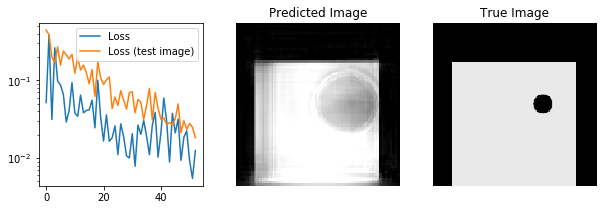

KeyboardInterrupt: 

In [6]:
batch_size=2
epochs=40


data = h5py.File('/data/Phantom/data.h5','r')
train_gen = mygenerator(data,'Train_X','Train_Y',batch_size)
val_gen = mygenerator(data,'Val_X','Val_Y',batch_size)

training_callback = TraingCallback()

model.fit_generator(generator=train_gen,
          validation_data=val_gen,
          epochs=epochs,
          callbacks=[training_callback],
          verbose=False
         );

model.save("TestModel.h5")

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [ ]:
data

In [ ]:
testim = x_val[0,...][np.newaxis,...]
output = model.predict(testim)
plt.imshow(output[0,:,:,8,0])
plt.colorbar()
plt.show()
plt.imshow(y_val[0,...,8,0])
plt.colorbar()
plt.show()

In [ ]:
predicted_image.shape

In [ ]:
testim = x_val[0,...][np.newaxis,...]
predicted_image = model.predict(x=testim)
predicted_image.shape